In [1]:
import sys
import os

# Obtener la ruta absoluta del directorio base usando rutas relativas
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))

# Agregar `src` a sys.path para que los imports funcionen
if BASE_DIR not in sys.path:
    sys.path.append(BASE_DIR)

print(BASE_DIR)

C:\Users\jeiso\Documents\Maestria\Semestre #1\NLP\IberLEF2025\MentalRiskES\src


In [2]:
import os
import torch
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from transformers import LongformerTokenizer, LongformerModel, AutoTokenizer, AutoModel
from text_processing import TextProcessing
from feature_extraction import FeatureExtraction
from pycaret.classification import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Get the root directory of the project (assuming the notebook is inside "notebook/")
notebook_dir = os.getcwd()  # Gets the current working directory
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))  # Moves one level up
project_root

'C:\\Users\\jeiso\\Documents\\Maestria\\Semestre #1\\NLP\\IberLEF2025\\MentalRiskES'

In [4]:
path_dataset = os.path.join(project_root, "data", "dataset_task2.xlsx")
dataset = pd.read_excel(path_dataset)
dataset['message'] = dataset['message'].fillna("").astype(str)
dataset.head()

,message,label_text,level,label
0,el canal del amigo se llama loco por el tradin...,trading,0,1
1,ganancia e ganancia chico [SEP] si lo conseguí...,trading,0,1
2,fijate cuanto e el margen en negativo y le agr...,trading,1,1
3,alguna entradita .. ? [SEP] spot está funciona...,trading,0,1
4,voy cargando la escopeta pa longuear alguna mo...,trading,1,1


In [5]:
x_task1 = dataset['message']
y_task1 = dataset['level']

In [6]:
# load model and tokenizer

# Longformer
#model_name = "PlanTL-GOB-ES/longformer-base-4096-bne-es"
#tokenizer = LongformerTokenizer.from_pretrained(model_name)
#model = LongformerModel.from_pretrained(model_name).to(device)

# BETO
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def get_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )
    # Mover los tensores de entrada a GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    # Convertir los resultados a CPU para trabajar con numpy
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()


# Aplicamos la función a todos los mensajes
x_task1_beto = np.array([get_embedding(text) for text in x_task1])
x_task1_beto

array([[-0.09902813, -0.15904334, -0.30138153, ..., -0.33458328,
         0.2695182 ,  0.22862685],
       [-0.14719549, -0.1112902 , -0.16692387, ..., -0.23385125,
         0.05203149,  0.10748015],
       [-0.1551729 , -0.03288925, -0.22002526, ..., -0.17964064,
         0.0976115 ,  0.19014117],
       ...,
       [ 0.13345632, -0.08678578, -0.04402681, ..., -0.30821866,
         0.23617628, -0.03853274],
       [ 0.2602157 ,  0.07340417,  0.06921416, ..., -0.2064684 ,
         0.52956724,  0.15044431],
       [-0.22404031,  0.09983473, -0.14697447, ..., -0.11260161,
         0.27668977,  0.23247115]], dtype=float32)

In [8]:
path_dataset_feature = os.path.join(project_root, "data", "dataset_task1.xlsx")
dataset_feature = pd.read_excel(path_dataset)
dataset_feature['message'] = dataset_feature['message'].fillna("").astype(str)
dataset_feature.head()

message  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      el canal del amigo se llama loco por el trading ? [SEP] hay vivo hoy ? [SEP] eos alguien lo vio ? [SEP] a que hora e el vivo ? [SEP] no arranca vet [SEP] pense que iba [SEP] puede caer hasta 0.14520 y de ahi subir [SEP] no hay vivo hoy ? [SEP] hay vivo [SEP] yo dot [SEP] yo sigo dot [SEP] soplen [SEP] y hay que ver [SEP] no hay vivo ? [SEP] que onda ? [SEP] ini_hashtag sorteocupoft end_hashtag [SEP] f hombro cabeza hombro ? [SEP] buenaaaa [SEP] q paso avax [SEP] btc [SEP] bnb [SEP] atom precio entrada [SEP] luna tb [SEP] la mande temprano [SEP] short a precio entrada mande temprano [SEP] no hay drama user 14042 estamos para ayudar [SEP] si atom y luna entre ma temprano puse sl en cero [SEP] no ya no la entrada era más arriba [SEP] igual te recomiendo x 5 u primero tratar 

In [9]:
x_task1_feature = dataset_feature['message']
y_task1_feature = dataset_feature['level']

In [10]:
lang = 'es'

ta = TextProcessing(lang=lang)
fe = FeatureExtraction(lang=lang)

def feature_extraction(message):
    try:
        # Limpiar y transformar el texto
        text_clean = ta.transformer(message)
        if text_clean is None or text_clean == '':
            return np.zeros(32)  # Ajusta el número según corresponda

        # Extraer características
        features = fe.get_features_lexical(text_clean)
        return features
    except Exception as e:
        print(f"Error procesando mensaje: {message[:50]}... - {str(e)}")
        return np.zeros(32)

In [11]:
feature_vectors = np.array([feature_extraction(text) for text in x_task1_feature])
feature_vectors

array([[ 19.30654588, 101.54933333,   0.        , ...,   0.        ,
          2.        ,   0.        ],
       [ 29.49604731, 138.95047619,   0.        , ...,   0.        ,
          1.        ,   0.        ],
       [ 23.89751242, 192.6       ,   0.        , ...,   0.        ,
          3.        ,   0.        ],
       ...,
       [  4.53232422,  12.7       ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  4.62103268,  12.10344828,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  5.39345238,   6.52173913,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [12]:
feature_vectors

array([[ 19.30654588, 101.54933333,   0.        , ...,   0.        ,
          2.        ,   0.        ],
       [ 29.49604731, 138.95047619,   0.        , ...,   0.        ,
          1.        ,   0.        ],
       [ 23.89751242, 192.6       ,   0.        , ...,   0.        ,
          3.        ,   0.        ],
       ...,
       [  4.53232422,  12.7       ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  4.62103268,  12.10344828,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  5.39345238,   6.52173913,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [13]:
if x_task1_beto.shape[0] != feature_vectors.shape[0]:
    raise ValueError(f"Los arrays tienen diferentes números de muestras: {x_task1_beto.shape[0]} vs {feature_vectors.shape[0]}")

In [14]:
x_combined = np.hstack((x_task1_beto, feature_vectors))

In [15]:
x_combined

array([[-0.09902813, -0.15904334, -0.30138153, ...,  0.        ,
         2.        ,  0.        ],
       [-0.14719549, -0.1112902 , -0.16692387, ...,  0.        ,
         1.        ,  0.        ],
       [-0.1551729 , -0.03288925, -0.22002526, ...,  0.        ,
         3.        ,  0.        ],
       ...,
       [ 0.13345632, -0.08678578, -0.04402681, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.2602157 ,  0.07340417,  0.06921416, ...,  0.        ,
         0.        ,  0.        ],
       [-0.22404031,  0.09983473, -0.14697447, ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
print('**Sample train:', sorted(Counter(y_task1).items()))

**Sample train: [(0, 178), (1, 231)]


In [17]:
# We create an instance of RandomOverSampler to balance the classes.
# - random_state=10000: A seed is set for reproducibility.

ros_task1 = RandomOverSampler(random_state=10000)

# We apply oversampling to generate new instances of the minority classes to equal the amount of the majority class.
x_combined, y_task1 = ros_task1.fit_resample(x_combined, y_task1)

# We show the distribution of classes after oversampling.
print('**OverSample train:', sorted(Counter(y_task1).items()))

**OverSample train: [(0, 231), (1, 231)]


In [18]:
x_combined

array([[-0.09902813, -0.15904334, -0.30138153, ...,  0.        ,
         2.        ,  0.        ],
       [-0.14719549, -0.1112902 , -0.16692387, ...,  0.        ,
         1.        ,  0.        ],
       [-0.1551729 , -0.03288925, -0.22002526, ...,  0.        ,
         3.        ,  0.        ],
       ...,
       [-0.14719549, -0.1112902 , -0.16692387, ...,  0.        ,
         1.        ,  0.        ],
       [-0.12730634, -0.09077215, -0.11596057, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02016972, -0.36212692, -0.10957462, ...,  0.        ,
         0.        ,  0.        ]])

In [19]:
setup_task1 = setup(
    data=x_combined, # Input data set (feature matrix)
    target=y_task1, # Target variable (classification labels)
    session_id=123, # Random seed to ensure reproducibility
    train_size=0.8, # Percentage of data used for training (80%)
    log_experiment=True, # Enable experiment logging (mlflow)
    experiment_name='Mentalrisk_task1_feature' # Name of experiment for tracking (mlflow)
)

,Description,Value
0,Session id,123
1,Target,level
2,Target type,Binary
3,Original data shape,"(462, 798)"
4,Transformed data shape,"(462, 798)"
5,Transformed train set shape,"(369, 798)"
6,Transformed test set shape,"(93, 798)"
7,Numeric features,797
8,Preprocess,True
9,Imputation type,simple


In [20]:
model_task1 = compare_models(fold=10)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:59:59
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7509,0.8278,0.7453,0.7606,0.7493,0.5016,0.5065,0.3240
et,Extra Trees Classifier,0.7479,0.8300,0.6594,0.8082,0.7241,0.4958,0.5070,0.0420
lightgbm,Light Gradient Boosting Machine,0.7344,0.8367,0.7020,0.7558,0.7259,0.4689,0.4729,0.1400
rf,Random Forest Classifier,0.7291,0.8221,0.6091,0.8022,0.6897,0.4567,0.4721,0.0650
ridge,Ridge Classifier,0.7209,0.7545,0.6968,0.7363,0.7128,0.4417,0.4459,0.0230
gbc,Gradient Boosting Classifier,0.7206,0.8115,0.6798,0.7411,0.7081,0.4407,0.4432,0.7100
lda,Linear Discriminant Analysis,0.7074,0.7194,0.6690,0.7332,0.6916,0.4143,0.4227,0.0270
ada,Ada Boost Classifier,0.6994,0.7628,0.6658,0.7291,0.6873,0.3999,0.4102,0.1600
dt,Decision Tree Classifier,0.6719,0.6719,0.6316,0.6907,0.6567,0.3435,0.3477,0.0360
nb,Naive Bayes,0.6505,0.6554,0.4360,0.7510,0.5453,0.2998,0.3280,0.0230


2025/04/09 00:00:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/09 00:00:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/09 00:00:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/09 00:00:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/09 00:00:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/09 00:00:25 

In [23]:
best_model = create_model('lr')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,00:01:14
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8378,0.8480,0.7368,0.9333,0.8235,0.6773,0.6936
1,0.7027,0.8158,0.6842,0.7222,0.7027,0.4058,0.4064
2,0.7838,0.8129,0.7895,0.7895,0.7895,0.5673,0.5673
3,0.7838,0.9240,0.7895,0.7895,0.7895,0.5673,0.5673
4,0.7568,0.8684,0.8421,0.7273,0.7805,0.5110,0.5179
5,0.6216,0.7047,0.5556,0.6250,0.5882,0.2405,0.2419
6,0.7027,0.8333,0.8333,0.6522,0.7317,0.4093,0.4249
7,0.8108,0.8655,0.7222,0.8667,0.7879,0.6197,0.6281
8,0.6757,0.7193,0.6667,0.6667,0.6667,0.3509,0.3509


2025/04/09 00:01:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


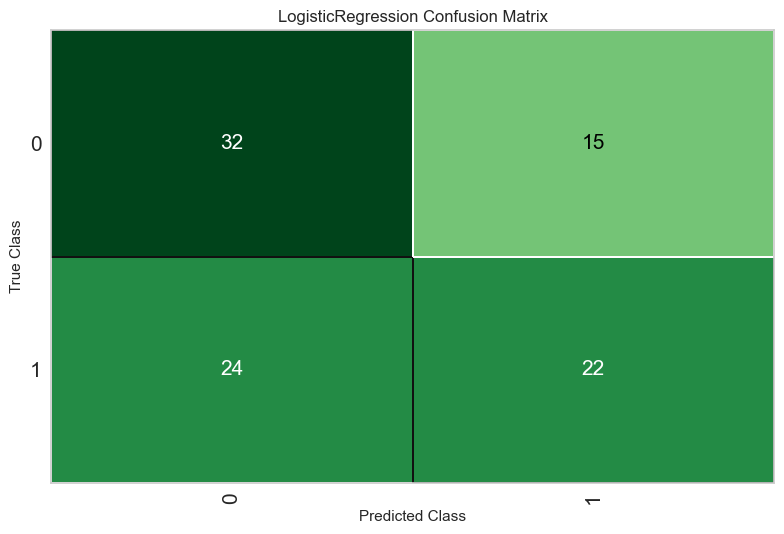

In [24]:
plot_model(best_model, plot='confusion_matrix')